In [1]:
import os
import random
import torch
import numpy as np

from grefer import G_REFER
from refer import REFER
from utils import ANSWER_LIST, SHORT_QUESTION_LIST

In [ ]:
# from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained(
#     "liuhaotian/llava-llama-2-13b-chat-lightning-preview",
#     cache_dir=None,
#     model_max_length=512,
#     padding_side="right",
#     use_fast=True,
# )

# conversation = "HUMAN: Could you point me to a engine component of this car? ### ASSISTANT: Sure, here is the engine component of the car."

# encoding = tokenizer.encode(conversation, return_offsets_mapping=True)
# offsets = encoding['offset_mapping']  # List of (start, end) tuples per token.

Reading [/shared/nas2/jk100/partonomy_private/src/models/PLUM/runs/plum-13b_kld_0.1_focal_tversky_8_v1_0shot_w_reasonseg/plum-13b_kld_0.1_focal_tversky_8_v1_0shot_w_reasonseg_bidirbio_2048_maxlen512_epochs25_bsz8_lr0.0003_bidir_bio_feedback_loop_train_prompt_enc_srates_5_9_5_1.json]
Reading [/shared/nas2/jk100/partonomy_private/src/models/PLUM/runs/plum-13b_kld_0.1_focal_tversky_8_v1_0shot_w_reasonseg/plum-13b_kld_0.1_focal_tversky_8_v1_0shot_w_reasonseg_bidirbio_2048_maxlen512_epochs25_bsz8_lr0.0003_bidir_bio_feedback_loop_train_prompt_enc_srates_9_5_5_1.json]


/tmp/ipykernel_975177/3670780351.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(results))


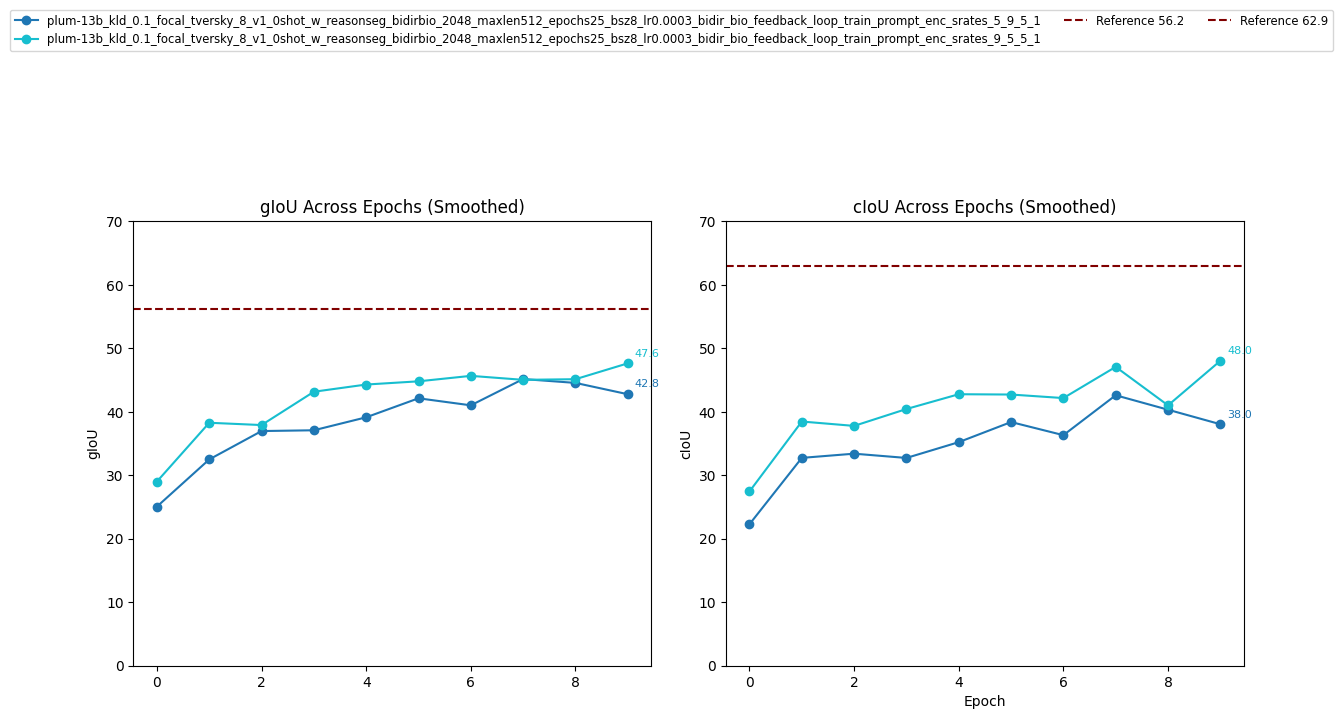

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

RESULT_DIRECTORY_PATHS = [
    "/shared/nas2/jk100/partonomy_private/src/models/PLUM/runs",
    "/shared/nas2/jk100/partonomy_private/src/models/lisa/runs",
]

def moving_average(values, window_size=3):
    """
    Returns a smoothed 1D array by applying a simple moving average.
    'valid' mode will shrink the output length to len(values) - window_size + 1.
    """
    return np.convolve(values, np.ones(window_size), 'valid') / window_size

# Dictionary to store results
results = {}

# Read data from result directory
for dir_path in RESULT_DIRECTORY_PATHS:
    for dp in os.listdir(dir_path):
        setting_path = os.path.join(dir_path, dp)
        # if os.path.isdir(setting_path) and '_reasonseg' in setting_path:
        if os.path.isdir(setting_path) and '_v1' in setting_path:
            # if os.path.isdir(setting_path) and '0shot' in setting_path:
            for file in sorted(os.listdir(setting_path)):
                if not file.endswith(".json"):
                    continue
                setting_key = os.path.splitext(file)[0]
                if setting_key not in results:
                    results[setting_key] = {"epochs": [], "giou": [], "ciou": []}
                    
                file_path = os.path.join(setting_path, file)
                print(f"Reading [{file_path}]")
                with open(file_path, "r") as f:
                    data = json.load(f)
                    for epoch_str, values in data.items():
                        epoch = int(epoch_str)
                        if "giou" in values and "ciou" in values:
                            results[setting_key]["epochs"].append(epoch)
                            results[setting_key]["giou"].append(100 * values["giou"])
                            results[setting_key]["ciou"].append(100 * values["ciou"])

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)
colors = plt.cm.get_cmap("tab10", len(results))

for idx, (setting_key, values) in enumerate(results.items()):
    # Sort epochs and associated giou/ciou
    sorted_data = sorted(zip(values["epochs"], values["giou"], values["ciou"]), key=lambda x: x[0])
    if len(values['epochs']) > 0:
        sorted_epochs, sorted_giou, sorted_ciou = zip(*sorted_data)
    
    sorted_epochs = np.array(sorted_epochs)
    sorted_giou = np.array(sorted_giou)
    sorted_ciou = np.array(sorted_ciou)
    
    # Smoothing with a rolling average (adjust window_size as needed)
    window_size = 3
    smoothed_giou = moving_average(sorted_giou, window_size)
    smoothed_ciou = moving_average(sorted_ciou, window_size)
    
    # Align epochs to match the 'valid' mode output
    smoothed_epochs = sorted_epochs[(window_size-1)//2 : -((window_size-1)//2)]
    
    # Plot original data (optional)
    line0 = axes[0].plot(sorted_epochs, sorted_giou, marker="o", label=f"{setting_key}", color=colors(idx))[0]
    line1 = axes[1].plot(sorted_epochs, sorted_ciou, marker="o", label=f"{setting_key}", color=colors(idx))[0]
    # Annotate the last point (most recent)
    last_epoch_giou = sorted_epochs[-1]
    last_value_giou = sorted_giou[-1]
    axes[0].annotate(f"{last_value_giou:.1f}",
                    (last_epoch_giou, last_value_giou),
                    textcoords="offset points",
                    xytext=(5, 5),
                    ha='left',
                    fontsize=8,
                    color=line0.get_color())

    last_epoch_ciou = sorted_epochs[-1]
    last_value_ciou = sorted_ciou[-1]
    axes[1].annotate(f"{last_value_ciou:.1f}",
                    (last_epoch_ciou, last_value_ciou),
                    textcoords="offset points",
                    xytext=(5, 5),
                    ha='left',
                    fontsize=8,
                    color=line1.get_color())

# Add horizontal reference lines
axes[0].axhline(56.2, color="maroon", linestyle="--", label="Reference 56.2")
axes[1].axhline(62.9, color="maroon", linestyle="--", label="Reference 62.9")

axes[0].set_title("gIoU Across Epochs (Smoothed)")
axes[0].set_ylabel("gIoU")
axes[1].set_title("cIoU Across Epochs (Smoothed)")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("cIoU")

# Set y-axis limits to flatten the graphs
axes[0].set_ylim(0, 70)
axes[1].set_ylim(0, 70)

# Create a common legend on top of the subplots
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicate labels while preserving order
unique = {}
for h, l in zip(handles, labels):
    if l not in unique:
        unique[l] = h
final_handles = list(unique.values())
final_labels = list(unique.keys())

# Place the legend at the top center of the figure
fig.legend(final_handles, final_labels, loc="upper center",
           ncol=3, fontsize="small", bbox_to_anchor=(0.5, 1.2))

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


In [ ]:
smoothed_epochs

In [ ]:
smoothed_giou

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size'      : 13,   # base size for everything
    'axes.titlesize' : 14,   # subplot titles
    'axes.labelsize' : 13,   # axis labels
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
})


# ---------------- data & styling (unchanged) ----------------
data = {}
data['PartImageNet'] = {
    'LISA-13B'          : {'id': 20.4, 'pos': 24.7, 'neg': 18.5},
    'LISA-13B (ft)'     : {'id': 0.00, 'pos': 0.00, 'neg': 0.00},
    'PixelILM-13B'      : {'id': 13.1, 'pos':  0.04, 'neg':  1.42},
    'PixelILM-13B (ft)' : {'id': 0.00, 'pos': 0.00,  'neg': 0.00},
    'GLaMM'             : {'id': 0.0, 'pos': 0.0, 'neg':  0.0},
    'GLaMM (ft)'        : {'id': 38.7, 'pos': 0.0, 'neg':  0.0},
    'PLUM'              : {'id': 26.2, 'pos': 29.3, 'neg':  7.1},
    'PLUM (ft)'         : {'id': 62.46, 'pos': 0.00, 'neg':  0.00},
}
data['PACO'] = {
    'LISA-13B'          : {'id': 8.19, 'pos': 5.74, 'neg': 3.87},
    'LISA-13B (ft)'     : {'id': 0.00, 'pos': 0.00, 'neg': 0.00},
    'PixelILM-13B'      : {'id': 0.03, 'pos':  1.50, 'neg':  0.09},
    'PixelILM-13B (ft)' : {'id': 0.00, 'pos': 0.00,  'neg': 0.00},
    'GLaMM'             : {'id': 0.0, 'pos': 0.0, 'neg':  0.0},
    'GLaMM (ft)'        : {'id': 0.0, 'pos': 0.0, 'neg':  0.0},
    'PLUM'              : {'id': 11.29, 'pos': 29.3, 'neg':  2.5},
    'PLUM (ft)'         : {'id': 26.343, 'pos': 0.00, 'neg':  0.00},
}
data['PascalParts'] = {
    'LISA-13B'          : {'id': 9.24, 'pos': 8.41, 'neg': 5.14},
    'LISA-13B (ft)'     : {'id': 20.1, 'pos': 21.5, 'neg': 13.2},
    'PixelILM-13B'      : {'id': 1.62, 'pos': 4.07, 'neg':  3.35},
    'PixelILM-13B (ft)' : {'id': 0.00, 'pos': 0.00,  'neg': 0.00},
    'GLaMM'             : {'id': 0.0, 'pos': 0.0, 'neg':  0.0},
    'GLaMM (ft)'        : {'id': 0.0, 'pos': 0.0, 'neg':  0.0},
    'PLUM'              : {'id': 26.2, 'pos': 29.3, 'neg':  2.5},
    'PLUM (ft)'         : {'id': 47.439, 'pos': 0.00, 'neg':  0.00},
}
data['Core'] = {
    'LISA-13B'          : {'id': 7.3, 'pos': 6.6, 'neg': 4.8},
    'LISA-13B (ft)'     : {'id': 0.0, 'pos': 0.0, 'neg':  0.0},
    'PixelILM-13B'      : {'id': 0.03, 'pos':  1.50, 'neg':  0.09},
    'PixelILM-13B (ft)' : {'id': 0.00, 'pos': 0.00,  'neg': 0.00},
    'GLaMM'             : {'id': 0.0, 'pos': 0.0, 'neg':  0.0},
    'GLaMM (ft)'        : {'id': 0.0, 'pos': 0.0, 'neg':  0.0},
    'PLUM'              : {'id': 11.7, 'pos': 12.4, 'neg':  2.5},
    'PLUM (ft)'         : {'id': 0.00, 'pos': 0.00, 'neg':  0.00},
}


datasets       = ['PACO', 'PartImageNet', 'PascalParts', 'Core']
models         = ['LISA-13B', 'PixelILM-13B', 'GLaMM', 'PLUM']
metric_keys    = ['id', 'pos', 'neg']
metric_labels  = {'id': 'Identification', 'pos': 'Intersection', 'neg': 'Part Difference'}
hatch_patterns = {'id': '//', 'pos': '..', 'neg': '\\\\'}
bar_width      = 0.50
palette = {
    'id' : ('#B7D4F1', '#3976B9'),
    'pos': ('#FFD3A1', '#E87E30'),
    'neg': ('#B5E3C8', '#3A9B6C'),
}

# ---------------- figure & axes ----------------
fig, axes = plt.subplots(
    nrows=1, ncols=len(datasets), sharey=True,
    figsize=(len(datasets) * 5.5, 5.5)          # width scales with #datasets
)

# In case len(datasets)==1, ensure axes is iterable
if len(datasets) == 1:
    axes = [axes]

# ---------------- plotting ----------------
for i, (ax, ds) in enumerate(zip(axes, datasets)):
    seen_metrics = set()
    
    if i == 0:
        ax.set_ylabel('gmIoU (%)')
    
    for i, model in enumerate(models):
        center_x = i * 1.5                           # group spacing
        
        for j, mkey in enumerate(metric_keys):
            x_pos     = center_x + (j - 1) * bar_width
            baseline  = data[ds][model][mkey]
            ft_val    = data[ds][f"{model} (ft)"][mkey]
            increment = ft_val - baseline
            
            # Baseline
            ax.bar(
                x_pos, baseline, width=bar_width,
                color=palette[mkey][0], edgecolor='black',
                hatch=hatch_patterns[mkey],
                label=f"{metric_labels[mkey]} (zero-shot)"
                      if mkey not in seen_metrics else None,
            )
            # Fine-tuned increment
            ax.bar(
                x_pos, increment, width=bar_width, bottom=baseline,
                color=palette[mkey][1], alpha=0.5,
                hatch=hatch_patterns[mkey],
                label=f"{metric_labels[mkey]} (ft)"
                      if mkey not in seen_metrics else None,
            )
            # Annotation
            ax.text(
                x_pos, ft_val + 1.0, f"{ft_val:.1f}",
                ha='center', va='bottom', fontsize=8
            )
            seen_metrics.add(mkey)
    
    ax.set_xticks([i * 1.5 for i in range(len(models))])
    ax.set_xticklabels(models, rotation=20, ha='right')
    ax.set_title(f'Partonomy-{ds}')
    ax.set_ylim(0, 65)

# # single y-label for the whole figure
# fig.text(0.04, 0.5, 'gmIoU (%)', va='bottom', rotation='vertical', fontsize=11)

# Global legend (grab handles from first axis)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=6)

fig.tight_layout(rect=[0, 0, 1, 0.90])  # leave room for legend
plt.show()


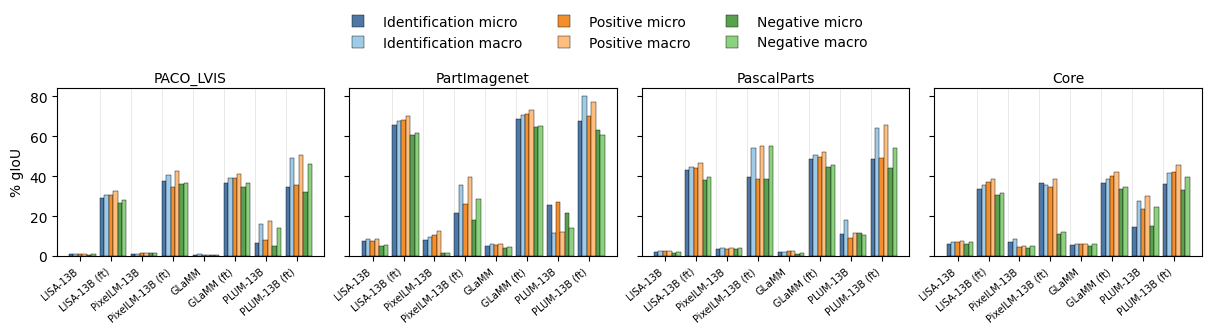

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------- Data ---------------------------------
records = []

def add(model, dataset, ident_micro, ident_macro,
        pos_micro, pos_macro, neg_micro, neg_macro):
    records.extend([
        (dataset, model, "Identification", "micro", ident_micro),
        (dataset, model, "Identification", "macro", ident_macro),
        (dataset, model, "Positive", "micro", pos_micro),
        (dataset, model, "Positive", "macro", pos_macro),
        (dataset, model, "Negative", "micro", neg_micro),
        (dataset, model, "Negative", "macro", neg_macro),
    ])

# PACO_LVIS
add("LISA-13B",          "PACO_LVIS", 0.82, 1.09, 0.98, 1.16, 0.65, 0.81)
add("LISA-13B (ft)",     "PACO_LVIS", 28.98, 30.69, 30.56, 32.40, 26.77, 28.01)
add("PixelLM-13B",       "PACO_LVIS", 0.92, 1.06, 1.29, 1.50, 1.28, 1.49)
add("PixelLM-13B (ft)",  "PACO_LVIS", 37.78, 40.54, 34.78, 42.66, 35.95, 36.48)
add("GLaMM",             "PACO_LVIS", 0.57, 0.78, 0.63, 0.75, 0.47, 0.58)
add("GLaMM (ft)",        "PACO_LVIS", 36.75, 39.25, 38.91, 41.16, 34.67, 36.73)
add("PLUM-13B",          "PACO_LVIS", 6.66, 15.96, 8.19, 17.34, 5.21, 14.31)
add("PLUM-13B (ft)",     "PACO_LVIS", 34.45, 49.41, 35.55, 50.81, 32.15, 46.08)

# PartImagenet
add("LISA-13B",          "PartImagenet", 7.41, 8.66, 7.39, 8.46, 5.01, 5.72)
add("LISA-13B (ft)",     "PartImagenet", 65.64, 67.65, 68.43, 70.38, 60.79, 61.50)
add("PixelLM-13B",       "PartImagenet", 7.96, 9.43, 10.31, 12.77, 1.49, 1.42)
add("PixelLM-13B (ft)",  "PartImagenet", 21.49, 35.71, 26.17, 39.64, 18.17, 28.71)
add("GLaMM",             "PartImagenet", 4.98, 6.13, 5.33, 5.85, 3.89, 4.64)
add("GLaMM (ft)",        "PartImagenet", 68.86, 70.75, 71.21, 73.10, 64.68, 65.41)
add("PLUM-13B",          "PartImagenet", 25.58, 11.63, 26.88, 12.23, 21.70, 13.98)
add("PLUM-13B (ft)",     "PartImagenet", 67.94, 80.30, 70.19, 77.39, 63.31, 60.66)

# PascalParts
add("LISA-13B",          "PascalParts", 2.19, 2.43, 2.35, 2.55, 1.67, 1.80)
add("LISA-13B (ft)",     "PascalParts", 42.94, 44.59, 44.24, 46.41, 38.19, 39.75)
add("PixelLM-13B",       "PascalParts", 3.57, 3.98, 3.66, 4.07, 3.65, 4.07)
add("PixelLM-13B (ft)",  "PascalParts", 39.87, 54.14, 38.80, 54.95, 38.81, 54.95)
add("GLaMM",             "PascalParts", 2.02, 2.05, 2.41, 2.37, 1.19, 1.37)
add("GLaMM (ft)",        "PascalParts", 48.81, 50.56, 49.82, 51.99, 44.57, 45.81)
add("PLUM-13B",          "PascalParts", 10.84, 17.98, 8.84, 11.56, 11.35, 10.69)
add("PLUM-13B (ft)",     "PascalParts", 48.42, 64.03, 49.31, 65.47, 44.39, 54.03)

# Core
add("LISA-13B",          "Core", 5.9, 7.0, 7.1, 7.5, 6.1, 7.1)
add("LISA-13B (ft)",     "Core", 33.6, 35.4, 37.0, 38.4, 30.4, 31.6)
add("PixelLM-13B",       "Core", 6.8, 8.4, 4.4, 4.8, 4.2, 4.8)
add("PixelLM-13B (ft)",  "Core", 36.8, 35.4, 34.7, 38.5, 11.2, 12.1)
add("GLaMM",             "Core", 5.3, 5.9, 5.9, 6.2, 5.2, 6.0)
add("GLaMM (ft)",        "Core", 36.6, 38.8, 40.3, 42.1, 33.6, 34.8)
add("PLUM-13B",          "Core", 14.5, 27.4, 23.7, 29.9, 14.9, 24.8)
add("PLUM-13B (ft)",     "Core", 36.2, 41.6, 42.1, 45.9, 33.0, 39.4)

df = pd.DataFrame(records, columns=["Dataset", "Model", "Task", "Metric", "Score"])

model_order = [
    "LISA-13B", "LISA-13B (ft)",
    "PixelLM-13B", "PixelLM-13B (ft)",
    "GLaMM", "GLaMM (ft)",
    "PLUM-13B", "PLUM-13B (ft)"
]
df["Model"] = pd.Categorical(df["Model"], categories=model_order, ordered=True)
df.sort_values(["Dataset", "Model"], inplace=True)

datasets_available = ["PACO_LVIS", "PartImagenet", "PascalParts", "Core"]
tasks = ["Identification", "Positive", "Negative"]
metrics = ["micro", "macro"]

palette = {
    "Identification-micro": "#4e79a7",
    "Identification-macro": "#a0cbe8",
    "Positive-micro":       "#f28e2c",
    "Positive-macro":       "#ffbe7d",
    "Negative-micro":       "#59a14f",
    "Negative-macro":       "#8cd17d",
}

# ------------------------- Plotting ---------------------------
n_ds = len(datasets_available)
fig, axes = plt.subplots(
    1, n_ds, figsize=(3.0 * n_ds, 2.6),
    sharey=True, constrained_layout=True
)
if n_ds == 1:
    axes = [axes]

bar_w = 0.78  # bar width
task_gap = bar_w * len(metrics)
model_gap = task_gap * len(tasks) + bar_w

for ax, ds in zip(axes, datasets_available):
    sub = df[df["Dataset"] == ds]
    for i, model in enumerate(model_order):
        for j, task in enumerate(tasks):
            for k, metric in enumerate(metrics):
                x = i * model_gap + j * task_gap + k * bar_w
                score_series = sub[
                    (sub["Model"] == model) &
                    (sub["Task"] == task) &
                    (sub["Metric"] == metric)
                ]["Score"]
                if not score_series.empty and not np.isnan(score_series.iloc[0]):
                    ax.bar(
                        x, score_series.iloc[0], bar_w,
                        color=palette[f"{task}-{metric}"],
                        edgecolor='black', linewidth=0.3
                    )
    # Vertical separators between models
    for i in range(1, len(model_order)):
        sep_x = i * model_gap - bar_w/2
        ax.axvline(sep_x, color="lightgrey", linewidth=0.5, alpha=0.7, zorder=0)
    # x‑axis ticks
    xticks = [i * model_gap + (task_gap * len(tasks))/2 - bar_w for i in range(len(model_order))]
    ax.set_xticks(xticks)
    ax.set_xticklabels(model_order, rotation=40, ha="right", fontsize=7)
    ax.set_title(ds, fontsize=10, pad=4)

axes[0].set_ylabel("% gIoU", fontsize=10)

# Legend on top centered
handles = [plt.Line2D([0], [0], marker='s', linestyle='', markersize=8,
                      markerfacecolor=palette[key], markeredgecolor='black', markeredgewidth=0.3)
           for key in palette]
labels = [key.replace("-", " ") for key in palette]

fig.legend(
    handles, labels, ncol=3, fontsize=10, frameon=False,
    loc="upper center", bbox_to_anchor=(0.5, 1.25)
)

plt.show()
